In [25]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
import math
from paq2py import *
from utils_funcs import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

%matplotlib notebook


# LOAD THE RAW DATA

<font color='blue'>Directory where the data is stored

In [3]:
directory = 'D:/analysis-diego-suite2p/IBL/'

paq_path = directory+'2019-07-25_DO006_001.paq'

raw_path = directory+'2019-07-25_FOV2-t003/suite2p/plane0/F.npy'
iscell_path = directory+'2019-07-25_FOV2-t003/suite2p/plane0/iscell.npy'


<font color='blue'>Directory where steering wheel task data is stored (pre-converted to numpy format)

In [4]:
directory_2 = directory + 'IBL-task-data_2019-07-25/'

choice_path = directory_2 + '_misc_trials.choice.npy'
contrastLeft_path = directory_2 + '_misc_trials.contrastLeft.npy'
contrastRight_path = directory_2 + '_misc_trials.contrastRight.npy'
feedback_times_path = directory_2 + '_misc_trials.feedback_times.npy'
feedbackType_path = directory_2 + '_misc_trials.feedbackType.npy'
GoCue_times_path = directory_2 + '_misc_trials.goCue_times.npy'
included_path = directory_2 + '_misc_trials.included.npy'
trial_intervals_path = directory_2 + '_misc_trials.intervals.npy'
probabilityLeft_path = directory_2 + '_misc_trials.probabilityLeft.npy'
repNum_path = directory_2 + '_misc_trials.repNum.npy'
response_times_path = directory_2 + '_misc_trials.response_times.npy'
rewardVolume_path = directory_2 + '_misc_trials.rewardVolume.npy'
stimOn_times_path = directory_2 + '_misc_trials.stimOn_times.npy'
wheel_position_path = directory_2 + '_misc_wheel.position.npy'
timestamps_path = directory_2 + '_misc_wheel.timestamps.npy'
wheel_velocity_path = directory_2 + '_misc_wheel.velocity.npy'
wheelMoves_intervals_path = directory_2 + '_misc_wheelMoves.intervals.npy'

<font color='blue'>Load data

In [6]:
wheel_velocity = np.load(wheel_velocity_path)
GoCue_times = np.load(GoCue_times_path)

raw = np.load(raw_path)
iscell = np.load(iscell_path)
raw = TraceExtractor(iscell,raw)
data = dfof(raw)

#read paq file using lloyds code
paq = paq_read(paq_path)
rate = paq['rate']

print(paq)

{'data': array([[0.00980016, 0.01045786, 0.01012901, ..., 0.00881361, 0.00815591,
        0.00848476],
       [0.00651166, 0.00618281, 0.00651166, ..., 0.00453857, 0.00552511,
        0.00355202],
       [0.00684051, 0.00684051, 0.00684051, ..., 0.00585396, 0.00552511,
        0.00585396]], dtype=float32), 'chan_names': ['frame_clock', 'IBL_trial', 'IBL_reward'], 'hw_chans': ['Dev1/ai0', 'Dev1/ai1', 'Dev1/ai2'], 'units': ['volts', 'volts', 'volts'], 'rate': 20000}


In [7]:
clock_idx = paq['chan_names'].index('frame_clock')
#voltage from the frame clock channel
clock_voltage = paq['data'][clock_idx, :]

#digitise frame clock, two clocks should not occur less than 10ms apart or more than 100ms apart
#frame_clock = np.digitise(clock_voltage, min_time = 0.01*paq['rate'], max_time = 0.1*paq['rate'])

frame_clock = threshold_detect(clock_voltage, 1)

# EXTRACT SELECTED EVENT TIMING

In [ ]:
#change this for the name of the event around which the STA will take place
#It has to be one of the events recorded in the paq file
selected_event = 'IBL_reward'

In [43]:
#name of the stimulus channel
stim_idx = paq['chan_names'].index(selected_event)
stim_volts = paq['data'][stim_idx, :]

#stims should not occur within 1ms of each other
stim_times = threshold_detect(stim_volts, 1)

<IPython.core.display.Javascript object>


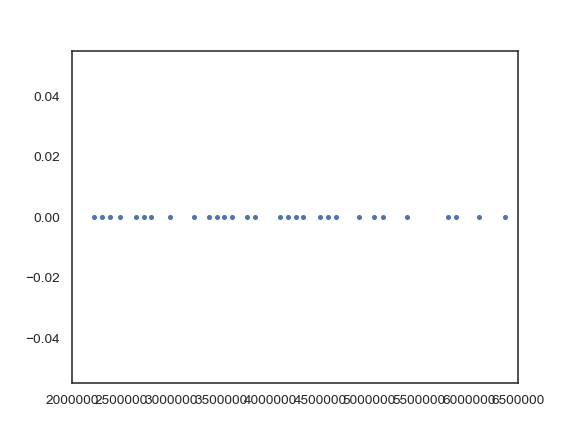

In [44]:
plt.figure()
#plt.plot(clock_voltage)
plt.plot(stim_times, np.zeros(len(stim_times)), '.')
plt.xlim((0.2e7, 0.65e7))
plt.show()

<font color='blue'>Do some magic to get the first frame before the event

In [45]:
#stim_times = np.delete(stim_times,[0,1,2,3,4,5,6,7])
#stim_times = np.delete(stim_times,[80,81,82,83])

stim_start_frames = []

stim_times_only_first = stim_times[5:80]

for stim in stim_times_only_first:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim > 0)
    #stim_start_frame = next(i-1 for i,sample in enumerate(clock_voltage) if sample - stim > 0)
    stim_start_frames.append(stim_start_frame)

stim_start_frames = np.array(stim_start_frames)


<font color='blue'>Define length of STA before and after the event

In [46]:
pre_frames = 90
post_frames = 90

#all observations before stimulus onset
pre_obs = []
#all observations post stimulus onset
post_obs = []

#3d array of trial binned data
trials = []

for stim in stim_start_frames:
  
    trial = data[:,stim-pre_frames:stim+post_frames]
    trials.append(trial)
    
    pre_stim  = data[:,stim-pre_frames:stim]
    post_stim = data[:,stim:stim+post_frames]

    [pre_obs.append(ob) for ob in pre_stim]
    [post_obs.append(ob) for ob in post_stim]
    
trials = np.stack(trials)
#trials = np.array(trials)
sta = np.mean(trials, 0)
sta_std = np.std(trials, 0)
    
#t_test = stats.ttest_ind(pre_obs, post_obs)   
#t_test

#selected_STAs = sta[[0,4,21]]

#np.save('selected-STAs_2019-07-23_FOV1.npy', selected_STAs)

# STA

<IPython.core.display.Javascript object>


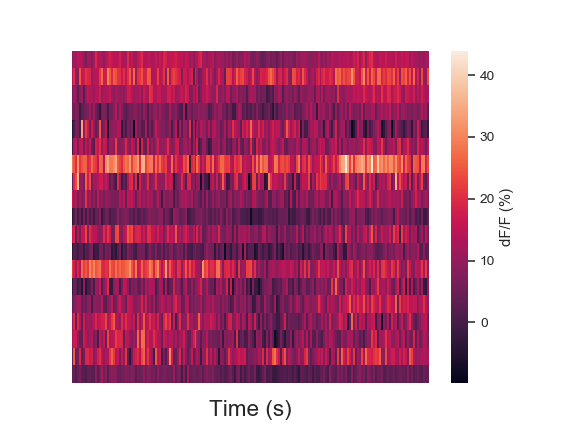

In [47]:
plt.figure()
ax = sns.heatmap(sta, cbar_kws={'label': 'dF/F (%)'})
ax.get_yaxis().set_visible(False)
plt.xlabel('Time (s)', size='18')
ax.set_xticklabels([])
plt.show()
plt.savefig("heatmap_STA_IBL-reward.png")

<font color='blue'>STA of one of the ROIs with trial-by-trial traces

<IPython.core.display.Javascript object>


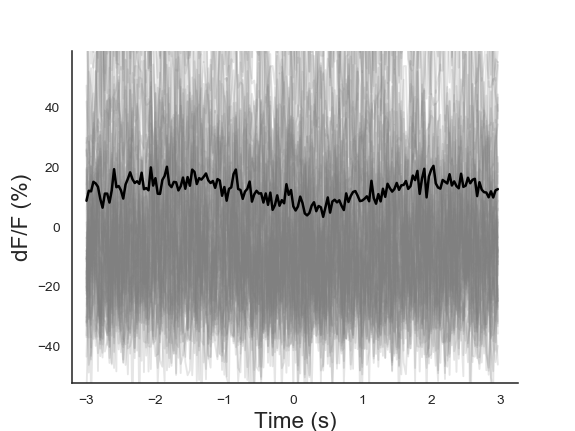

In [48]:
ROI = 0
frame_rate = 30
x_axis = (np.arange(sta.shape[1]) - pre_frames) / frame_rate

sta_trials = trials[:,ROI,...]

plt.figure()
#[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in sta]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in sta_trials]
#plt.plot(x_axis, np.mean(sta,0))
plt.plot(x_axis, sta[ROI], c='black', linewidth=2)
#plt.fill_between(x_axis, sta[ROI]-sta_std[ROI],sta[ROI]+sta_std[ROI], color='0.85')
#plt.axvline(x=0,c='red', linewidth=4)
#plt.plot([0] * 100, np.linspace(np.min(trials), np.max(trials), 100), '--')
#plt.plot([1] * 100, np.linspace(np.min(trials), np.max(trials), 100), '--')
plt.xlabel('Time (s)', size='18')
plt.ylabel('dF/F (%)', size='18')
#plt.ylim([-100,200])

sns.despine()
plt.show()
plt.savefig("STA_IBL-trial.TIFF")

<font color='blue'>Plot some traces for a sanity check by eye and optionally plot events in the traces

In [34]:
reward_start_frames = stim_start_frames 

<IPython.core.display.Javascript object>


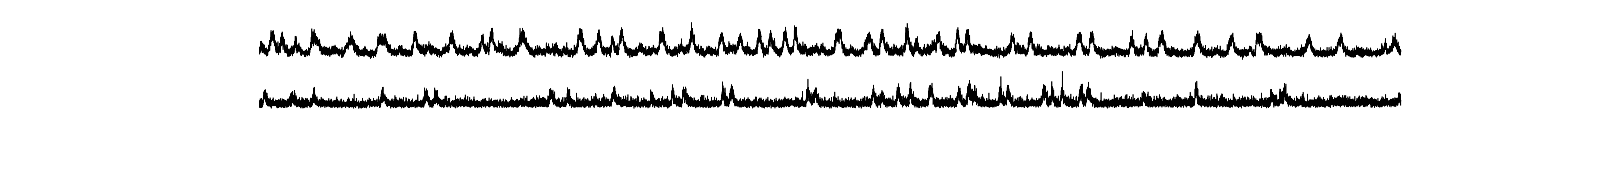

In [35]:
x_axis = np.arange(data.shape[1])

plt.figure(figsize=(18,2))

plt.subplot(3, 1, 1)
plt.plot(x_axis,data[0],c='black', linewidth=0.5)
plt.axis('off')
sns.despine()

plt.subplot(3, 1, 2)
plt.plot(x_axis,data[1],c='black', linewidth=0.5)
plt.axis('off')
plt.axis('off')

#plt.plot(x_axis,raw[0],c='green', linewidth=0.5)
#plt.plot(stim_start_frames, np.zeros(len(stim_start_frames)), '.')
#sns.despine()
#for trial_start in trial_start_frames:
#    plt.axvline(x=trial_start,c='blue', linewidth=2)
#for start in stim_start_frames:
#    plt.axvline(x=start,c='red', linewidth=2)
#plt.xlim((0, 36000))

plt.show()
plt.savefig("foo_4.TIFF")

# Plot information related to the steering wheel task

In [75]:
wheel_velocity = np.squeeze(wheel_velocity)
GoCue_times = np.squeeze(GoCue_times)

<IPython.core.display.Javascript object>


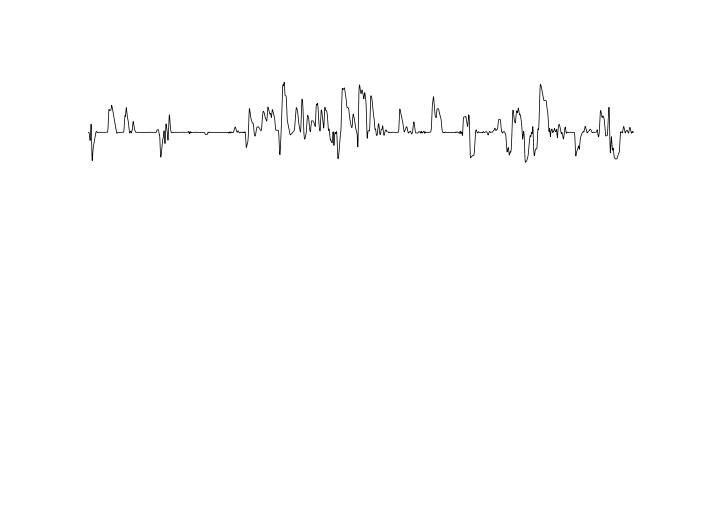

In [89]:
x_axis = np.arange(len(wheel_velocity))

plt.figure()

plt.subplot(3, 1, 1)
plt.plot(x_axis,wheel_velocity,c='black', linewidth=0.5)
plt.axis('off')
sns.despine()
plt.xlim((0, 60000))
plt.show()
#plt.savefig("foo_4.TIFF")

<IPython.core.display.Javascript object>


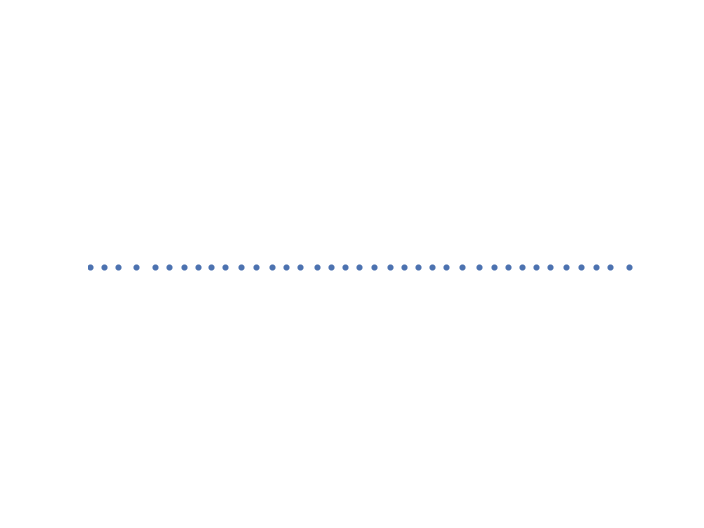

In [80]:
plt.figure()

plt.plot(GoCue_times, np.zeros(len(GoCue_times)), '.')
plt.axis('off')
sns.despine()
plt.xlim(150, 300)
plt.show()